In [180]:
import os

import holidays

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


In [75]:
from glob import glob
glob('*')

['DK-DK2.csv', 'Untitled.ipynb']

# Data Exploration

In [76]:
df = pd.read_csv('DK-DK2.csv')
df.columns

Index(['datetime', 'timestamp', 'zone_name', 'carbon_intensity_avg',
       'carbon_intensity_production_avg', 'carbon_intensity_discharge_avg',
       'carbon_intensity_import_avg', 'carbon_rate_avg',
       'total_production_avg', 'total_storage_avg', 'total_discharge_avg',
       'total_import_avg', 'total_export_avg', 'total_consumption_avg',
       'production_sources', 'power_origin_percent_fossil_avg',
       'power_origin_percent_renewable_avg', 'power_production_biomass_avg',
       'power_production_coal_avg', 'power_production_gas_avg',
       'power_production_hydro_avg', 'power_production_nuclear_avg',
       'power_production_oil_avg', 'power_production_solar_avg',
       'power_production_wind_avg', 'power_production_geothermal_avg',
       'power_production_unknown_avg', 'power_consumption_biomass_avg',
       'power_consumption_coal_avg', 'power_consumption_gas_avg',
       'power_consumption_hydro_avg', 'power_consumption_nuclear_avg',
       'power_consumption_oil_av

In [77]:
df['zone_name'].drop_duplicates()

0    DK-DK2
Name: zone_name, dtype: object

In [78]:
df = df.drop(['zone_name', 'timestamp'],axis=1) #zone name is the same for all in this subdata set, timestamp seems redundant, or for something else


In [79]:
#check no duplicate timestamps
len(df), len(df.drop_duplicates('datetime'))

(41932, 41932)

In [80]:
# Look at how many rows have na values
len(df), len(df.dropna()), len(df.dropna(axis=1,how='all').dropna())

(41932, 0, 24676)

In [81]:
df = df.dropna(axis=1,how='all') # remove columns with only nan
df.columns
#Add yesterday's carbon intensity as a feature
df['yesterday_carbon_intensity_avg'] = df['carbon_intensity_avg'].shift(24)
df['2dayold_carbon_intensity_avg'] = df['carbon_intensity_avg'].shift(24*2)
df['weekold_carbon_intensity_avg'] = df['carbon_intensity_avg'].shift(24*7)
df.yesterday_carbon_intensity_avg

0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
            ...    
41927    154.215621
41928    176.374831
41929    219.838187
41930    188.903759
41931    182.023117
Name: yesterday_carbon_intensity_avg, Length: 41932, dtype: float64

In [82]:
#parse timestamp into index
df.index = pd.to_datetime(df['datetime'])
df.index.name = 'UTC'

#get holidays, day of week, local hour including dst, 
df['local_time'] = df.tz_convert('Europe/Copenhagen').index
dk_holidays = holidays.DK()
df['holiday?'] = df.local_time.map(lambda x: x in dk_holidays)

df['weekday'] = df.local_time.map(lambda x: x.weekday)
df['weekend?'] = df.weekday.map(lambda x: x < 5)

In [83]:
#Split into training set, validation set, test set to compare models
train_val_df, test_df = train_test_split(df, test_size=4000, random_state=42, shuffle=False)
train_df, val_df = train_test_split(train_val_df, test_size=4000, random_state=42, shuffle=False)
len(train_df), len(val_df), len(test_df)

(33932, 4000, 4000)

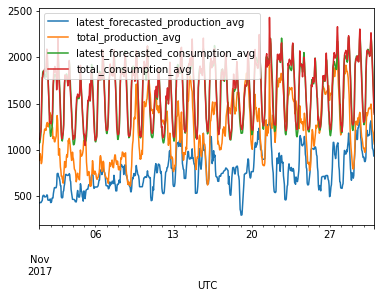

In [84]:
#check out consumption and production forecasts vs actual - why is production so different from consumption? - imports
train_df['2017-11'][['latest_forecasted_production_avg','total_production_avg','latest_forecasted_consumption_avg','total_consumption_avg']].plot()


C:\Users\Rob\Anaconda3\envs\tomorrow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Rob\Anaconda3\envs\tomorrow\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<Figure size 720x720 with 0 Axes>

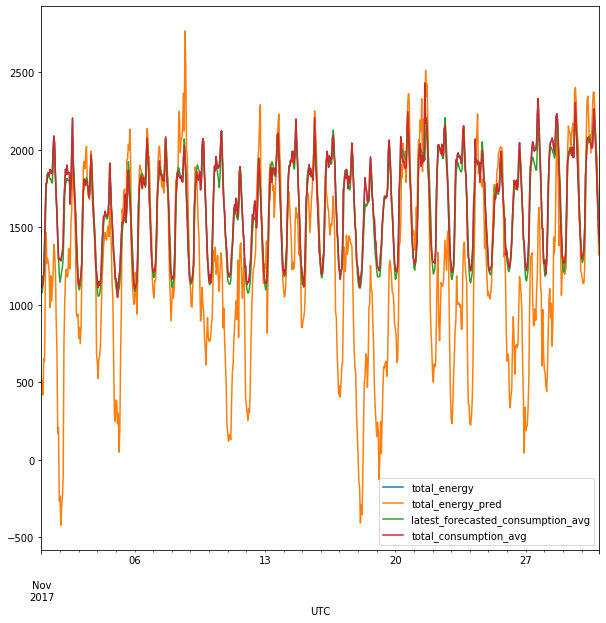

In [85]:
train_df['total_energy_pred'] = train_df['latest_forecasted_production_avg'] + df['latest_forecasted_power_net_import_DE_avg'] + df['latest_forecasted_power_net_import_DK-DK1_avg'] + df['latest_forecasted_power_net_import_SE-SE4_avg']
train_df['total_energy'] = train_df['total_production_avg'] + train_df['power_net_import_DK-DK1_avg'] + train_df['power_net_import_DE_avg'] + train_df['power_net_import_SE_avg']

plt.figure(figsize=(10,10))
train_df['2017-11'][['total_energy','total_energy_pred','latest_forecasted_consumption_avg','total_consumption_avg']].plot(figsize=(10,10))
plt.show()

In [86]:
#Note - forecasted consumption is actually much closer to final energy in the system than forecasted production + forecasted imports. 
#Question - Does Production here just include day ahead, or DA + intraday, or DA + Intra + imbalance?
mse_cons_energy = ((train_df.latest_forecasted_consumption_avg - train_df.total_energy)**2).mean()
mse_energy_energy = ((train_df.total_energy_pred - train_df.total_energy)**2).mean()
mse_cons_energy, mse_energy_energy

(5922.037070649313, 145809.0530682819)

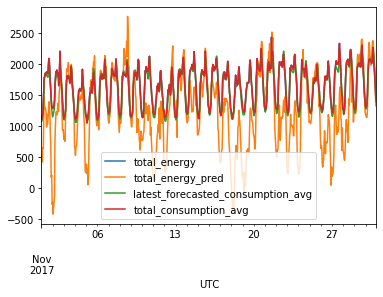

In [87]:
train_df['2017-11'][['total_energy','total_energy_pred','latest_forecasted_consumption_avg','total_consumption_avg']].plot()


latest_forecasted_dewpoint_avg, correlation: (-0.4121637725745628, 0.0)
latest_forecasted_precipitation_avg, correlation: (-0.10545716524061838, 1.6085889297564957e-43)
latest_forecasted_solar_avg, correlation: (-0.14544499658749996, 2.9570193424980383e-103)
latest_forecasted_temperature_avg, correlation: (-0.42904310489582725, 0.0)
latest_forecasted_wind_x_avg, correlation: (-0.26161003289763796, 0.0)
latest_forecasted_wind_y_avg, correlation: (0.011643606107062665, 0.0857510674646353)
latest_forecasted_price_avg, correlation: (0.20390387298482154, 6.85379148166477e-310)
latest_forecasted_production_avg, correlation: (0.5042651375155861, 0.0)
latest_forecasted_consumption_avg, correlation: (0.25358391046981715, 0.0)
latest_forecasted_power_net_import_DE_avg, correlation: (0.2784666788188, 0.0)
latest_forecasted_power_net_import_DK-DK1_avg, correlation: (0.19323499929162125, 9.962004932456339e-278)
latest_forecasted_power_net_import_SE-SE4_avg, correlation: (-0.3397151869598589, 0.0)
l

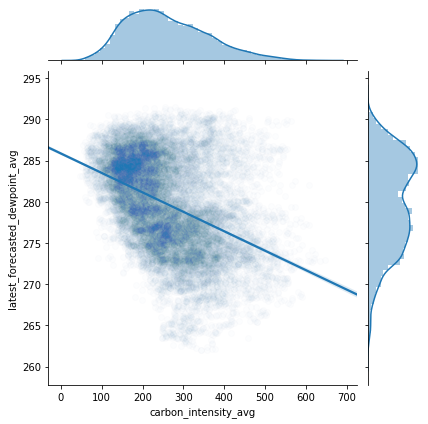

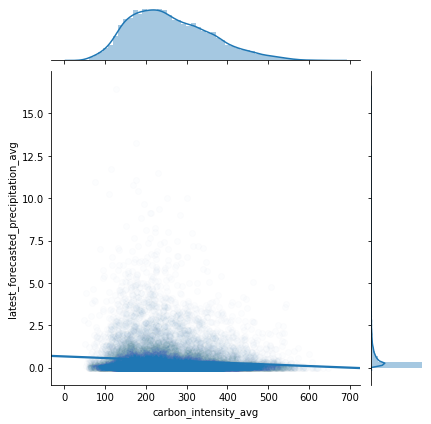

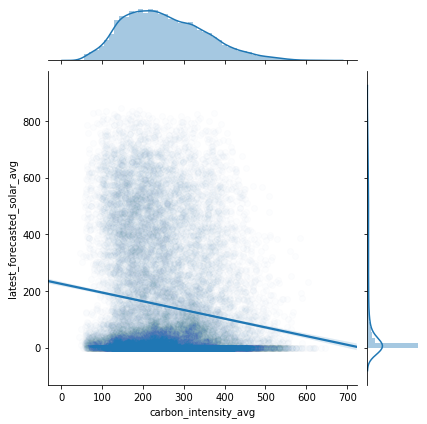

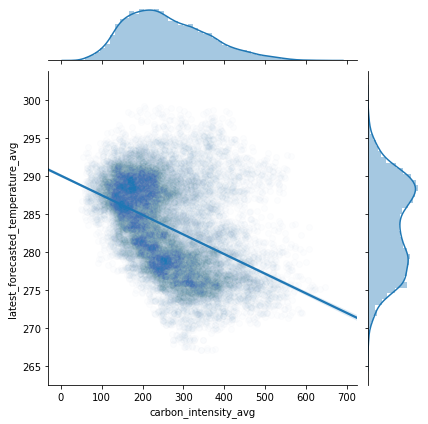

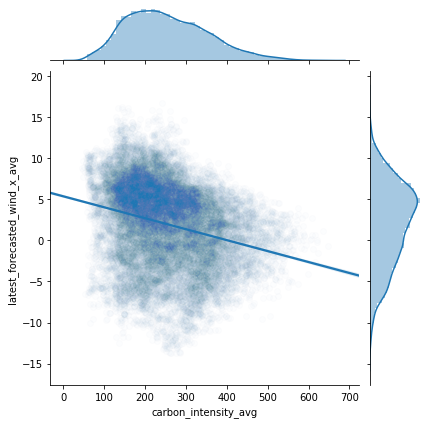

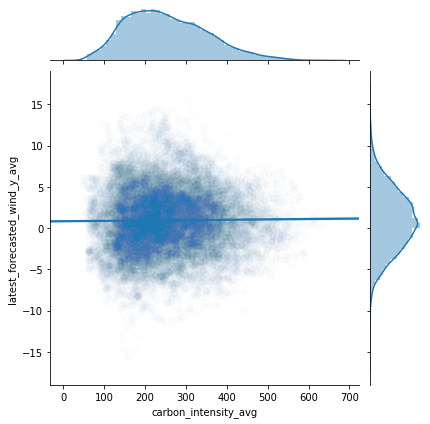

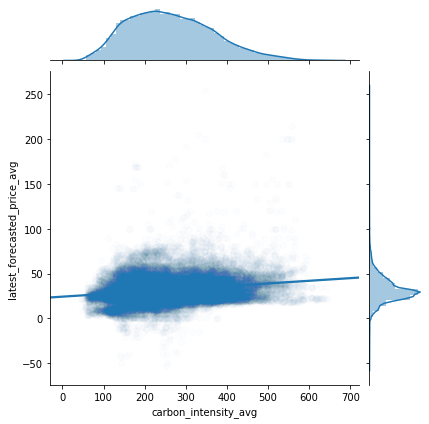

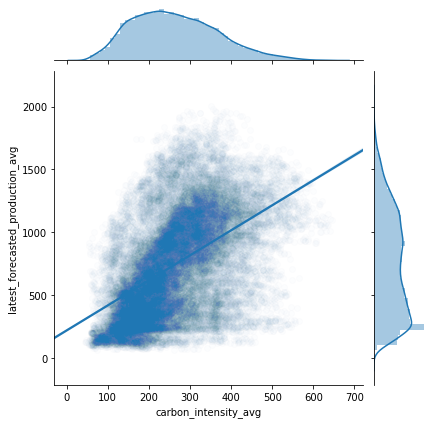

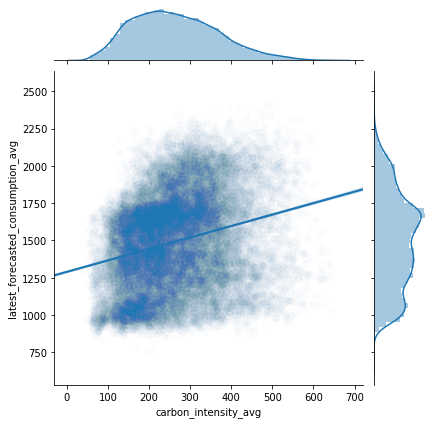

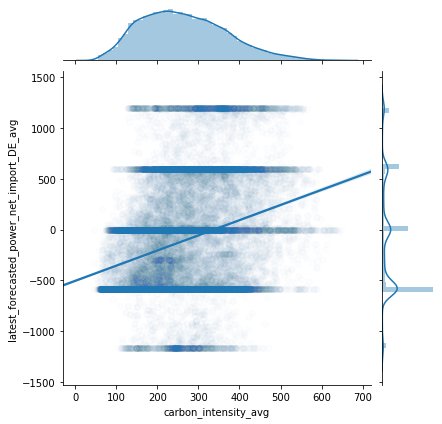

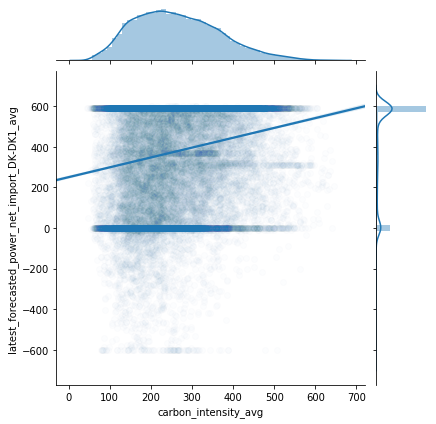

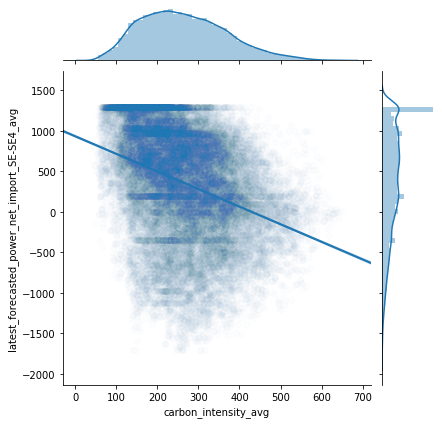

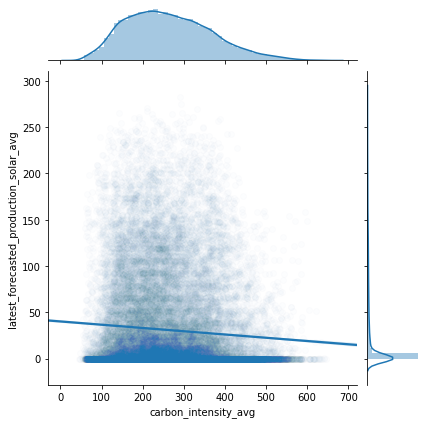

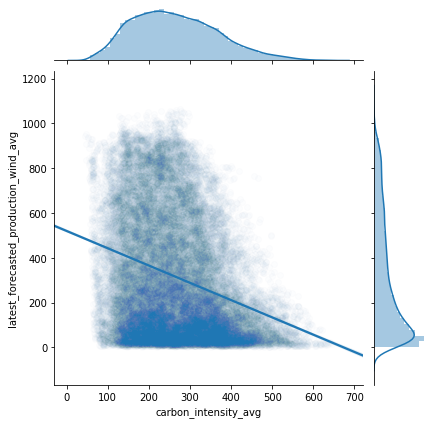

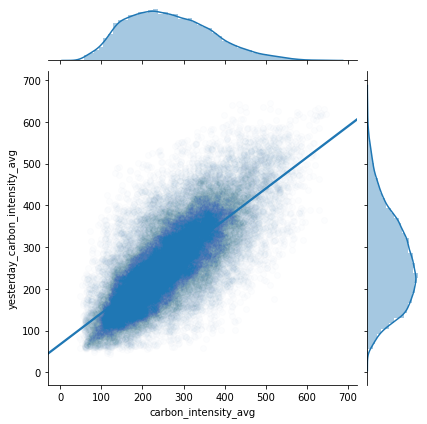

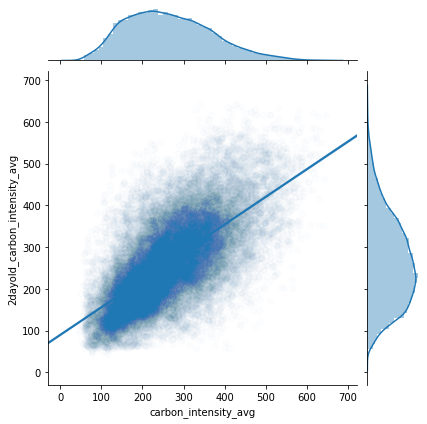

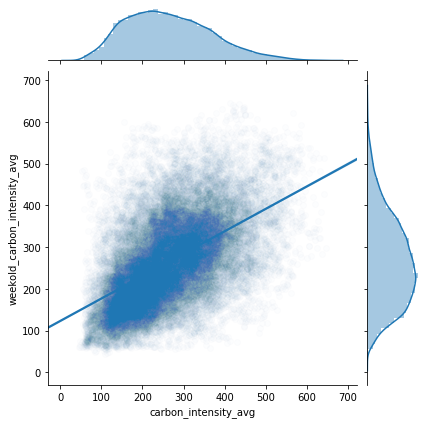

In [71]:
#For each numeric column, scatter plot vs carbon intensity,
for column in train_df.select_dtypes(include=[np.number]).columns:
    if ('latest_forecast' in column) | ('_carbon_intensity_avg' in column):
        corr_df = train_df[['carbon_intensity_avg',column]].dropna() #remove nans
        print(column + ', correlation: ' + str(pearsonr(corr_df['carbon_intensity_avg'],corr_df[column])))
        sns.jointplot(y=train_df[column], x=train_df['carbon_intensity_avg'], kind='reg',scatter_kws={'alpha':0.01})
        
        
#From these, it looks like latest_forecasted_production_avg is a good feature, 
#   whereas latest_forecasted_consumption_avg isn't, even though latest_forecasted_consumption_avg
#   appears to be a more accurate forecast of the actual energy in the system    
#Other important features: latest_forecasted_temperature_avg, latest_forecasted_dewpoint_avg,
              

#interesting - precipitation appears poorly correlated with carbon intensity
#Question - how could wind direction be helpful?

#Imports do not appear to be good indicators, although the import combined with the price point in the zones might be?
#Import from SE4 - export does not seem to max out at ~1400 like import does, is this an error? or is there
#     somehow higher capacity into DK2 from SE than out?

#I would expect latest forecasted price to be a better indicator of carbon intensity due to merit order

#Best indicator appears to be yesterday's carbon intensity - although it might not be fair to use yesterday's
#   since depending on where the data comes from you may not have that information by the time you forecast tomorrow.
#   but it is probably fair to use 2 day old intensity?


In [151]:
# split into x and y, normalize
#from sklearn.preprocessing import StandardScaler
x_cols = ['latest_forecasted_dewpoint_avg', 'latest_forecasted_precipitation_avg',
       'latest_forecasted_solar_avg', 'latest_forecasted_temperature_avg',
       'latest_forecasted_wind_x_avg', 'latest_forecasted_wind_y_avg',
       'latest_forecasted_price_avg', 'latest_forecasted_production_avg',
       'latest_forecasted_consumption_avg',
       'latest_forecasted_power_net_import_DE_avg',
       'latest_forecasted_power_net_import_DK-DK1_avg',
       'latest_forecasted_power_net_import_SE-SE4_avg',
       'latest_forecasted_production_solar_avg',
       'latest_forecasted_production_wind_avg', '2dayold_carbon_intensity_avg',
       'weekold_carbon_intensity_avg', 'holiday?', #'weekday',
       'weekend?']
y_col = ['carbon_intensity_avg']

#remove nans
train = train_df[x_cols+y_col].dropna()
val = val_df[x_cols+y_col].dropna()
test = test_df[x_cols+y_col].dropna()

#scaler = StandardScaler()

train_x = train[x_cols].values
train_y = train[y_col].values
val_x = val[x_cols].values
val_y = val[y_col].values
test_x = test[x_cols].values
test_y = test[y_col].values

# Compare Models

### Model 1 - Persistence

In [152]:
#Use MSE as mean squared error

#Test - How good is persistence - using yesterday, 2 days ago, and week ago?
# This is the baseline.
mse_yest = mean_squared_error(val_df['carbon_intensity_avg'].values, val_df['yesterday_carbon_intensity_avg'])
mse_2day = mean_squared_error(val_df['carbon_intensity_avg'].values, val_df['2dayold_carbon_intensity_avg'])
mse_week = mean_squared_error(val_df['carbon_intensity_avg'].values, val_df['weekold_carbon_intensity_avg'])
mse_yest, mse_2day, mse_week

(5330.1000614924205, 6938.747000368644, 8475.86267565703)

### Model 2 -  Linear Regression

In [153]:
from sklearn import linear_model
model = linear_model.LinearRegression()
model.fit(train_x, train_y)
val_y_pred = model.predict(val_x)
mse_linear = mean_squared_error(val_y, val_y_pred)
mse_linear

2046.0847016395444

### Model 3 - Simple MLP

In [154]:
from sklearn.neural_network import MLPRegressor
model = MLPRegressor()
model.fit(train_x, train_y)
val_y_pred = model.predict(val_x)
mse_mlp = mean_squared_error(val_y, val_y_pred)
mse_mlp, model.n_layers_

C:\Users\Rob\Anaconda3\envs\tomorrow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(1909.5142245230581, 3)

In [155]:
model = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15,), random_state=42)
model.fit(train_x, train_y)
val_y_pred = model.predict(val_x)
mse_mlp = mean_squared_error(val_y, val_y_pred)
mse_mlp, model.n_layers_

C:\Users\Rob\Anaconda3\envs\tomorrow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(1426.067912859676, 3)

In [156]:
model = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15,15,), random_state=42)
model.fit(train_x, train_y)
val_y_pred = model.predict(val_x)
mse_mlp = mean_squared_error(val_y, val_y_pred)
mse_mlp, model.n_layers_

C:\Users\Rob\Anaconda3\envs\tomorrow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(1488.7168354302821, 4)

In [157]:
model = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(50,50,50), random_state=42)
model.fit(train_x, train_y)
val_y_pred = model.predict(val_x)
mse_mlp = mean_squared_error(val_y, val_y_pred)
mse_mlp, model.n_layers_

C:\Users\Rob\Anaconda3\envs\tomorrow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(1427.589303689491, 5)

In [158]:
model = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(50,25,5), random_state=42)
model.fit(train_x, train_y)
val_y_pred = model.predict(val_x)
mse_mlp = mean_squared_error(val_y, val_y_pred)
mse_mlp, model.n_layers_

C:\Users\Rob\Anaconda3\envs\tomorrow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(1437.492297664142, 5)

In [159]:
model = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(50,), random_state=42)
model.fit(train_x, train_y)
val_y_pred = model.predict(val_x)
mse_mlp = mean_squared_error(val_y, val_y_pred)
mse_mlp, model.n_layers_

C:\Users\Rob\Anaconda3\envs\tomorrow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(1504.2285971748781, 3)

In [160]:
model = MLPRegressor(solver='lbfgs', alpha=1e-5, activation = 'tanh', hidden_layer_sizes=(15,), random_state=42)
model.fit(train_x, train_y)
val_y_pred = model.predict(val_x)
mse_mlp = mean_squared_error(val_y, val_y_pred)
mse_mlp, model.n_layers_

C:\Users\Rob\Anaconda3\envs\tomorrow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(5481.98908703611, 3)

In [161]:
#Best of these appears to be simple 1 hidden layers with 15 neurons - How does this weight the different features?
model = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15,), random_state=42)
model.fit(train_x, train_y)
val_y_pred = model.predict(val_x)
mse_mlp = mean_squared_error(val_y, val_y_pred)
mse_mlp, model.n_layers_

C:\Users\Rob\Anaconda3\envs\tomorrow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(1426.067912859676, 3)

In [144]:
model.coefs_[0].shape

(18, 15)

In [ ]:
#Interesting - MLP and linear regressor performed much better without normalization

# Create Production Forecast Classes

In [ ]:
# Now we need some functions to call
# some assumptions: we may want to be able to forecast retroactively - 
# ideally in database we would timestamp when we receive/update all data, so we can easily
#    bring database back to point in time, and perform forecasts from data we actually
#    had at the time, in order to accurately backtest forecasting models.,
# But assuming we just have csv file.. 

# What would we like user experience to be? - call carbonIntensityForecast, be able to choose 
# between different models potentially, although customer facing should be our production model


import carbonIntensityForecaster()
foc = carbonIntensityForecaster() #will default to production model
foc = carbonIntensityForecaster(model='new_fancy_model') #will test new fancy model
foc.forecast() #if no date given, will default to next 24 hours        
foc.forecast('2018-01-01') #will forecast single date

In [193]:
class productionModel():
    def __init__(self):
        self.xcols = ['latest_forecasted_dewpoint_avg', 'latest_forecasted_precipitation_avg',
               'latest_forecasted_solar_avg', 'latest_forecasted_temperature_avg',
               'latest_forecasted_wind_x_avg', 'latest_forecasted_wind_y_avg',
               'latest_forecasted_price_avg', 'latest_forecasted_production_avg',
               'latest_forecasted_consumption_avg',
               'latest_forecasted_power_net_import_DE_avg',
               'latest_forecasted_power_net_import_DK-DK1_avg',
               'latest_forecasted_power_net_import_SE-SE4_avg',
               'latest_forecasted_production_solar_avg',
               'latest_forecasted_production_wind_avg', '2dayold_carbon_intensity_avg',
               'weekold_carbon_intensity_avg', 'holiday?', 
               'weekend?']
        self.ycol = ['carbon_intensity_avg']
    
models = dict(production = productionModel)

config = dict(data_path = 'DK-DK2.csv')

def getStartEnd(date):
    if date == 'next24':
        start = pd.Timestamp.now(tz='UTC').round('1h') + pd.DateOffset(hours=1)
        
    else:
        try: 
            start = pd.Timestamp(date, tz='Europe/Copenhagen')
        except:
            raise 'Could not parse date input: "%s"'%date
    end = start + pd.DateOffset(days=1)
    return start.tz_convert('UTC'), end.tz_convert('UTC')

class carbonIntensityForecaster():
    def __init__(self, modelName='production',config=config):
        self.modelName = modelName
        self.config = config
        self.data = self.load_data()
        self.model = models[modelName]()
        
    def load_data(self):
        fp = self.config['data_path']
        assert os.path.exists(fp), 'Data File not found at %s'%fp
        try:
            df = pd.read_csv(fp)
        except:
            raise 'Error reading data file in %s'%fp
            
        df['yesterday_carbon_intensity_avg'] = df['carbon_intensity_avg'].shift(24)
        df['2dayold_carbon_intensity_avg'] = df['carbon_intensity_avg'].shift(24*2)
        df['weekold_carbon_intensity_avg'] = df['carbon_intensity_avg'].shift(24*7)
        
        #parse timestamp into index
        df.index = pd.to_datetime(df['datetime'])
        df.index.name = 'UTC'

        #get holidays, day of week, local hour including dst, 
        df['local_time'] = df.tz_convert('Europe/Copenhagen').index
        dk_holidays = holidays.DK()
        df['holiday?'] = df.local_time.map(lambda x: x in dk_holidays)

        df['weekday'] = df.local_time.map(lambda x: x.weekday)
        df['weekend?'] = df.weekday.map(lambda x: x < 5)
        return df
    
    def forecast(self, date='next24'):
        start, end = getStartEnd(date)
        datetimes = pd.date_range(start,end,freq='H',closed='right')
        
        model_df = self.data[self.model.xcols + self.model.ycol]
        
        #drop nans
        model_df = model_df.dropna(subset=self.model.xcols)
        
        #split into x, y
        x_df = model_df[self.model.xcols]
        y_df = model_df[self.model.ycol]
        
        #check that we have features for all datetimes.
        for dt in datetimes:
            assert dt in x_df.index, 'Error, some data missing from datafile for %s, forecast could not be produced'%dt
        
        #split into train, test
        train_x = x_df[:start].values
        train_y = y_df[:start].values
        test_x = x_df[start:end].values
        test_y = y_df[start:end].values
        
        model.fit(train_x,train_y)
        y_pred = model.predict(test_x)
        y_pred = pd.Series(y_pred,index=y_df[start:end].index)
        return y_pred
            
foc = carbonIntensityForecaster()
foc.forecast('2018-01-01')

C:\Users\Rob\Anaconda3\envs\tomorrow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


UTC
2017-12-31 23:00:00+00:00    200.080995
2018-01-01 00:00:00+00:00    195.363484
2018-01-01 01:00:00+00:00    190.548261
2018-01-01 02:00:00+00:00    184.586112
2018-01-01 03:00:00+00:00    159.158293
2018-01-01 04:00:00+00:00    151.635797
2018-01-01 05:00:00+00:00    149.572475
2018-01-01 06:00:00+00:00    157.392152
2018-01-01 07:00:00+00:00    170.258996
2018-01-01 08:00:00+00:00    151.434812
2018-01-01 09:00:00+00:00    155.902590
2018-01-01 10:00:00+00:00    151.609444
2018-01-01 11:00:00+00:00    136.320149
2018-01-01 12:00:00+00:00    135.080191
2018-01-01 13:00:00+00:00    139.255223
2018-01-01 14:00:00+00:00    148.619342
2018-01-01 15:00:00+00:00    164.239536
2018-01-01 16:00:00+00:00    187.323281
2018-01-01 17:00:00+00:00    167.128830
2018-01-01 18:00:00+00:00    174.742950
2018-01-01 19:00:00+00:00    189.585804
2018-01-01 20:00:00+00:00    148.464163
2018-01-01 21:00:00+00:00    153.313408
2018-01-01 22:00:00+00:00    181.088365
2018-01-01 23:00:00+00:00    221.165